In [3]:
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'

# native
import sys
import os
from os import listdir
from collections import defaultdict
from PIL import Image
import pprint as pp
import functools
import pickle
import re

# math
import numpy as np
from sklearn.metrics import accuracy_score

# plotting
import matplotlib
from matplotlib import pyplot as plt

# extra
from tqdm import tqdm
import logging

# pytorch
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils import model_zoo

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models


In [4]:
requirements = {
    torch: '1',
    matplotlib: '3'
}

def check_requirements(requirements):
    for requirement in requirements:
        error_message = '{} environment does not match requirement'.format(requirement.__name__)
        assert (requirement.__version__[0] == requirements[requirement]), error_message

check_requirements(requirements)

In [5]:
cuda = torch.cuda.is_available()

if cuda:
    torch.backends.cudnn.benchmark = True
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

device = 'cuda' if cuda else 'cpu'

device

'cuda'

In [6]:
class PlotGrid:
    def __init__(self, figsize=None):
        self.fig = plt.figure(figsize=figsize)
        self.ax = {}
        self.xlim = {}
        self.ylim = {}
        self.filled = {}
        self.grid = {}
    
    def plot(self, position_id, data, title=None, xlim=None, ylim=None, filled=None, grid=None):
        if position_id in self.ax:
            ax = self.ax[position_id]
        else:
            ax = self.fig.add_subplot(*position_id)

        # cache current values
        if title is None:
            title = ax.get_title()

        if xlim is not None:
            self.xlim[position_id] = xlim

        if ylim is not None:
            self.ylim[position_id] = ylim

        if filled is not None:
            self.filled[position_id] = filled
        
        if position_id not in self.filled:
            self.filled[position_id] = True

        if grid is not None:
            self.grid[position_id] = grid
        
        if position_id not in self.grid:
            self.grid[position_id] = True

        ax.cla()
        ax.clear()
        if type(data).__name__ == 'Image':
            ax.imshow(data)
        else:
            if hasattr(data, 'is_cuda') and data.is_cuda:
                data = data.cpu()
            if hasattr(data, 'numpy'):
                data = data.numpy()
            ax.plot(data)

            if self.filled[position_id]:
                ax.fill_between(range(len(data)), data)

            if self.grid[position_id]:
                ax.grid(True)

            # set xlim
            if position_id in self.xlim:
                ax.set_xlim(*self.xlim[position_id])

            # set ylim
            if position_id in self.ylim:
                ax.set_ylim(*self.ylim[position_id])
        
        # set title
        if title is not None:
            ax.set_title(title)

        self.fig.tight_layout()
        self.fig.canvas.draw()
        self.ax[position_id] = ax
    
    def prediction_plot(self, position_id, data, title=None, grid=None):
        if position_id in self.ax:
            ax = self.ax[position_id]
        else:
            ax = self.fig.add_subplot(*position_id)

        # cache current values
        if title is None:
            title = ax.get_title()

        if grid is not None:
            self.grid[position_id] = grid
        
        if position_id not in self.grid:
            self.grid[position_id] = True

        ax.cla()
        ax.clear()
        plot_data = data[2]
        plot_labels = data[1]
        if hasattr(plot_data, 'is_cuda') and plot_data.is_cuda:
            plot_data = plot_data.cpu()
        if hasattr(plot_data, 'numpy'):
            plot_data = plot_data.numpy()

        ticks = range(len(plot_data)-1, -1, -1)

        ax.barh(ticks, plot_data, align='center')

        if self.grid[position_id]:
            ax.grid(True)

        # set xlim
        ax.set_xlim(0, 1)

        # set y labels
        ax.set_yticks(ticks)
        ax.set_yticklabels(plot_labels)
        
        # set title
        if title is not None:
            ax.set_title(title)

        self.fig.tight_layout()
        self.fig.canvas.draw()
        self.ax[position_id] = ax
    
    def savefig(self, filename):
        figure_directory = os.path.join('results', 'activation-plots')
        os.makedirs(figure_directory, exist_ok=True)
        figure_path = os.path.join(figure_directory, filename)
        self.fig.savefig(figure_path, bbox_inches='tight')


In [7]:
def pathJoin(*args):
    return os.path.abspath(os.path.join(*args))


def pprint(*args):
    pp.pprint(*args)


def rgetattr(obj, attr, *args):
    def _getattr(obj, attr):
        return getattr(obj, attr, *args)
    return functools.reduce(_getattr, [obj] + attr.split('.'))


def smooth(x, span=10):
    return [ np.mean(x[i:i+span]) for i in range(len(x) - span + 1)]


toPILImage = transforms.ToPILImage()

softmax = torch.nn.Softmax(dim=1)


In [8]:
class BaseDataset(Dataset):

    def __init__(self, directory, split='train', transforms=None):
        self.datapoints = defaultdict(list)
        self.split = split
        self.directory = pathJoin(directory, split)
        self.datapoints, self.groundtruths = self.loadDataset()
        self.transforms = transforms

    def __len__(self):
        return len(self.datapoints)

    def __getitem__(self, idx):
        datapoint = self.loadDatapoint(idx)
        return datapoint

    def loadDatapoint(self, idx):
        raise NotImplementedError('Function "loadDatapoint" is not implemented')

    def loadDataset(self, name):
        raise NotImplementedError('Function "loadDataset" is not implemented')


In [9]:
class TinyImageNetDataset(BaseDataset):

    def __init__(self, directory, split='train', transforms=None):
        super().__init__(directory, split, transforms)
        self.descriptions = self.loadDescriptions()
        self.classes = self.loadClasses()
        self.imagenet_classes = self.loadImageNetClasses()

    def loadDatapoint(self, idx):
        filepath = self.datapoints[idx]
        image = Image.open(filepath).convert('RGB')
        groundtruth = self.groundtruths[idx]
        if self.transforms:
            image = self.transforms(image)
        return (filepath, image, groundtruth, self.descriptions[groundtruth], self.classes.index(groundtruth))

    def loadDataset(self):
        datapoints = []
        groundtruths = []

        if self.split is 'train':
            class_directories = os.listdir(self.directory)
            for classname in tqdm(class_directories):
                class_path = pathJoin(self.directory, classname, 'images')
                for filename in os.listdir(class_path):
                    datapoints.append(pathJoin(class_path, filename))
                    groundtruths.append(classname)
        elif self.split is 'val':
            dataset_file_list_filename = 'val_annotations.txt'
            dataset_file_list_path = os.path.join(self.directory, dataset_file_list_filename)

            with open(dataset_file_list_path, 'r') as dataset_file_list_file:
                for line in tqdm(dataset_file_list_file, total=sum(1 for line in open(dataset_file_list_path))):
                    filename, annotation, *_ = line.split('\t')
                    file_path = pathJoin(self.directory, 'images', self.sanitizeFilename(filename))
                    datapoints.append(file_path)
                    groundtruths.append(annotation)

        return datapoints, groundtruths
    
    def sanitizeFilename(self, filename):
        return filename.replace('"', '').strip()

    def loadDescriptions(self):
        descriptions = {}

        descriptions_filename = 'words.txt'
        descriptions_path = pathJoin(self.directory, '..', descriptions_filename)

        with open(descriptions_path, 'r') as descriptions_file:
            for line in descriptions_file:
                line = line.strip()
                description_breakdown = line.split('\t')
                descriptions[description_breakdown[0]] = description_breakdown[1]

        return descriptions

    def loadClasses(self):
        classes = []

        classes_filename = 'wnids.txt'
        classes_path = pathJoin(self.directory, '..', classes_filename)

        with open(classes_path, 'r') as classes_file:
            for line in classes_file:
                classes.append(line.strip())

        return classes

    def loadImageNetClasses(self):
        classes = []

        classes_filename = 'synsets.txt'
        classes_path = pathJoin(self.directory, '..', classes_filename)

        with open(classes_path, 'r') as classes_file:
            for line in classes_file:
                classes.append(line.strip())

        return classes
    
    def imagenetidx2class(self, idx):
        return self.imagenet_classes[idx]
    
    def imagenetidx2label(self, idx):
        return self.descriptions[self.imagenetidx2class(idx)]
    
    def idx2class(self, idx):
        return self.classes[idx]
    
    def idx2label(self, idx):
        return self.descriptions[self.idx2class(idx)]


In [10]:
class DeNormalize(object):
    # Source: https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/3
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, image):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        tensor = image.clone()
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor


In [11]:
TRAIN_BATCH_SIZE = 128
TEST_BATCH_SIZE = 512

imagenet_normalization_values = {
    'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225]
}

normalize = transforms.Normalize(**imagenet_normalization_values)
denormalize = DeNormalize(**imagenet_normalization_values)


def toImage(tensor_image):
    return toPILImage(denormalize(tensor_image))

train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    normalize
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    normalize
])

tinyimagenet_dataset_path = os.path.join('datasets', 'tiny-imagenet-200')

tinyimagenet_train_dataset = TinyImageNetDataset(tinyimagenet_dataset_path, transforms=train_transforms)
tinyimagenet_val_dataset = TinyImageNetDataset(tinyimagenet_dataset_path, split='val', transforms=test_transforms)
# tinyimagenet_test_dataset = TinyImageNetDataset(tinyimagenet_dataset_path, split='test')

tinyimagenet_train_loader = DataLoader(tinyimagenet_train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
tinyimagenet_val_loader = DataLoader(tinyimagenet_val_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)
# tinyimagenet_test_loader = DataLoader(tinyimagenet_test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)


100%|██████████| 10000/10000 [00:00<00:00, 23013.14it/s]


In [12]:
# def imshow(img):
#     img = denormalize(img)
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

# # get some random training images
# dataiter = iter(tinyimagenet_train_loader)
# _, images, _, labels, _ = dataiter.next()

# # show images
# imshow(torchvision.utils.make_grid(images))
# # print labels
# print(' '.join('%5s' % labels[j] for j in range(4)))

In [13]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 64, 5)
        self.fc1 = nn.Linear(64 * 16, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 200)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

<IPython.core.display.Javascript object>


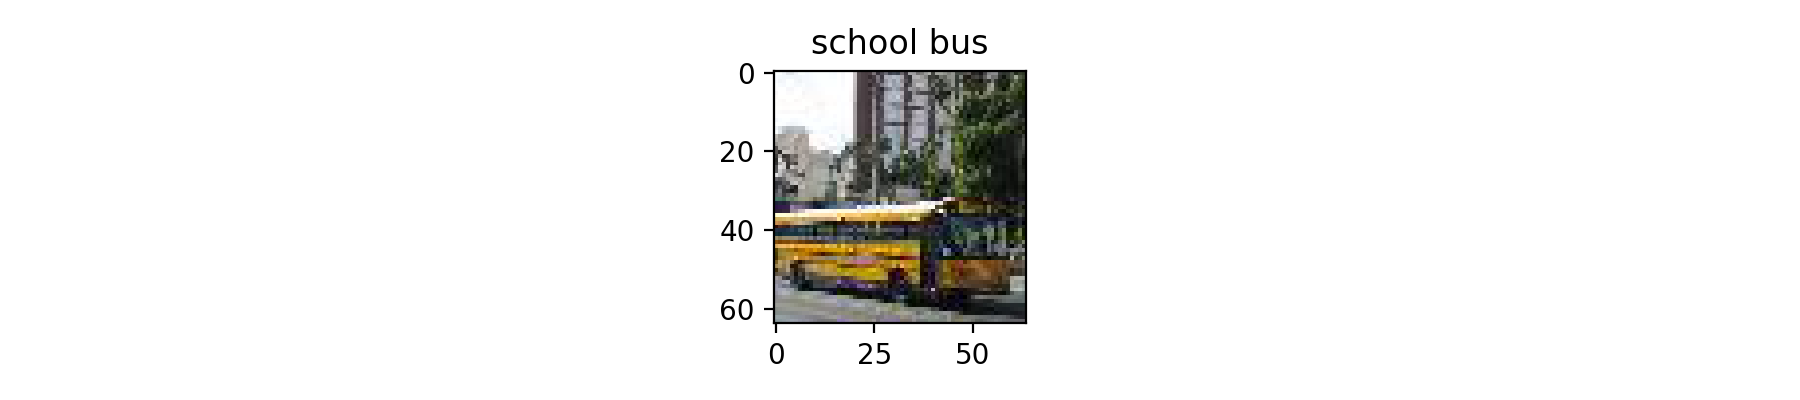

In [14]:
image_grid = PlotGrid(figsize=(9,2))

In [15]:
for index, image in enumerate(tinyimagenet_val_dataset):
    img = image[1]
    image_grid.plot((1, 1, 1), toImage(img), title=image[3])
    if (index + 1) == 9:
        break

In [16]:
def create_vgg19(architecture='vanilla', initialization='all'):
    pretrained = (initialization is 'all')
    
    # load model from pytorch
    vgg19 = models.vgg19(pretrained=pretrained)
    # always load in eval mode
    vgg19.eval();

#     if initialization is 'all':
#         # freeze cnn layers
#         for param in vgg19.parameters():
#             param.requires_grad = False
    
#     vgg19.features = vgg19.features[:-9]

    # change classifer to fit tinyimagenet
#     vgg19.classifier = torch.nn.Sequential(
#         torch.nn.Linear(in_features=8192, out_features=4096, bias=True),
#         torch.nn.ReLU(inplace=True),
#         torch.nn.Dropout(p=0.5),
#         torch.nn.Linear(in_features=4096, out_features=512, bias=True),
#         torch.nn.ReLU(inplace=True),
#         torch.nn.Dropout(p=0.5),
#         torch.nn.Linear(in_features=512, out_features=200, bias=True)
#     )
    vgg19.classifier = torch.nn.Sequential(
        torch.nn.Linear(in_features=2048, out_features=1024, bias=True),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(p=0.5),
        torch.nn.Linear(in_features=1024, out_features=512, bias=True),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(p=0.5),
        torch.nn.Linear(in_features=512, out_features=200, bias=True)
    )
    return vgg19

# def create_cnn():
    

# vanilla_vgg19_pretrained = create_vgg19('vanilla', 'all')
# vanilla_vgg19_scratch = create_vgg19('vanilla', 'none')

In [17]:
def validate(model, dataloader, monitor, logger):
    logger.info('Validation Start')
    model.eval()
    
    correct = []

    if monitor:
        validation_grid = PlotGrid(figsize=(9,3))
        validation_grid.plot((1, 2, 1), np.mean(correct), title='Validation Accuracy', filled=False, ylim=(0,1))

    for batch_index, batch in enumerate(dataloader):
        output = model(batch[1].to(device))
        target = batch[4].to(device)

        _, predicted_class = output.topk(1, 1, True, True)
        predicted_descriptions = [ dataloader.dataset.imagenetidx2label(x) for x in predicted_class.squeeze() ]
        batch_results = target == predicted_class.squeeze()
        batch_results = (target == predicted_class.squeeze()).cpu().numpy()
        correct.extend(batch_results)
        if monitor:
            validation_grid.plot((1, 2, 1), np.mean(correct), title='Validation Accuracy {0:.4f}'.format(np.mean(correct)))
            validation_grid.plot((1, 2, 2), toImage(batch[1][0]), title='True: {}\n Predicted: {}'.format(batch[3][0], predicted_descriptions[0]))

        if (batch_index + 1) % 10 == 0:
            logger.info('Validation Batch {0}:'
                        'Accuracy {1:.4f}'.format(batch_index + 1, np.mean(correct)))

    logger.info('Validation End')
    return np.mean(correct)

# validate(vanilla_vgg19_pretrained, tinyimagenet_val_loader, monitor=True)

In [18]:
architectures = ['vanilla']
initializations = ['all', 'none']

print('{}-{}\t:\t{}'.format('arch', 'init', 'predicted class'))
for architecture in architectures:
    for initialization in initializations:
        model = create_vgg19(architecture, initialization)
        output = model(img.unsqueeze(0).cuda())
        print('{}-{}\t:\t{}'.format(architecture, initialization, output.topk(1,1)[1].item()))

arch-init	:	predicted class
vanilla-all	:	168
vanilla-none	:	103


In [19]:
def train(model, dataloader, criterion, optimizer, monitor, logger):
    logger.info('Training Start')
    model.train()

    if monitor:
        train_grid = PlotGrid(figsize=(9,3))

    loss = []
    accuracy = []

    for batch_index, batch in enumerate(dataloader):
        optimizer.zero_grad()
        output = model(batch[1].to(device))
        target = batch[4].to(device)

        # accuracy
        _, predicted_class = output.topk(1, 1, True, True)
        batch_results = (target == predicted_class.squeeze()).cpu().numpy()
        accuracy.append(np.mean(batch_results))

        # loss
        batch_loss = criterion(output, target)
        loss.append(batch_loss.item())
        
        # backprop
        batch_loss.backward()
        optimizer.step()
        
        # plot
        if monitor:
            train_grid.plot((1, 2, 1), smooth(loss, 10), title='Train Loss {0:.4f}'.format(loss[-1]), filled=False)
            train_grid.plot((1, 2, 2), smooth(accuracy, 10), title='Train Accuracy {0:.4f}'.format(accuracy[-1]), filled=False, ylim=(0,1))
            
        if (batch_index + 1) % 10 == 0:
            logger.info('Training Batch {0}: Accuracy {1:.4f} Loss {2:.4f}'.format(batch_index + 1, accuracy[-1], loss[-1]))

    logger.info('Training End')
    return accuracy[-1], loss[-1]

def run(run_name, model, training, number_of_epochs, monitor, logger):

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    best_validation_accuracy = 0

    for epoch in range(1, number_of_epochs + 1):
        if training:
            train_accuracy, train_loss = train(model, tinyimagenet_train_loader, criterion, optimizer, monitor, logger)
        validation_accuracy = validate(model, tinyimagenet_val_loader, monitor, logger)
        logger.info('Epoch {0}: Train Loss: {1:.4f} Train Accuracy: {2:.4f} Validation Accuracy: {3:.4f}'.format(epoch, train_loss, train_accuracy, validation_accuracy))
        if validation_accuracy > best_validation_accuracy:
            logger.info('Improved Validation Score, saving new weights')
            model_directory = pathJoin('models', 'vgg19')
            os.makedirs(model_directory, exist_ok=True)
            checkpoint = {
                'epoch': epoch,
                'train_accuracy': train_accuracy,
                'train_loss': train_loss,
                'validation_accuracy': validation_accuracy,
                'weights': model.state_dict()
            }
            torch.save(checkpoint, pathJoin(model_directory, 'epoch-{}-{}.ckpt'.format(epoch, run_name)))
            best_validation_accuracy = validation_accuracy


In [20]:
def create_logger(log_directory, filename):
    logger = logging.getLogger()
    logging.getLogger('matplotlib.axes._base').setLevel(logging.ERROR)

    def exceptionLogger(exceptionType, exceptionValue, exceptionTraceback):
        logger.error("Uncaught Exception", exc_info=(exceptionType, exceptionValue, exceptionTraceback))

    sys.excepthook = exceptionLogger

    logging.basicConfig(
        handlers=[
            logging.FileHandler(os.path.join(log_directory, '{}.log'.format(filename))),
            logging.StreamHandler(sys.stdout)
        ],
        level=logging.DEBUG,
        format='%(asctime)s %(name)s %(levelname)s %(message)s'
    )

    return logger


In [21]:
architectures = ['vanilla']
initializations = ['all', 'none']

training = True
epochs = 100
monitor = False

architecture = architectures[0]
initialization = initializations[0]
load_model = True

run_name = 'vgg19_{}_{}'.format(architecture, initialization)
pprint(run_name)
log_directory = pathJoin('run_logs')
os.makedirs(log_directory, exist_ok=True)
logger = create_logger(log_directory, run_name)
# model = create_vgg19(architecture, initialization)
# run(run_name, net, training, epochs, monitor, logger)
# model.features[:-18]


'vgg19_vanilla_all'


In [31]:
# for a, b in model.named_parameters():
#     print(a)
vgg19 = models.vgg19(pretrained=True)
# vgg16 = models.vgg16()
pprint(vgg19)
# pprint(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [108]:
# def insert_instance_normalization(layer_index, model):
#     model.features[:layer_index]
#     model.features[layer_index:]
# x = [5, 3, 2, 1]
# pprint(vgg19)
# x.insert(1, 4)
# vgg19.insert(20, torch.nn.InstanceNorm(256))
# pprint(vgg19)



In [109]:
pprint(img.unsqueeze(0).shape)
vgg_in = VGG_IN(21)
vgg_in(img.unsqueeze(0).cuda())

torch.Size([1, 3, 64, 64])


tensor([[-0.0517,  0.2568, -0.0868,  0.1826,  0.1030, -0.0314,  0.1070,  0.2408,
          0.0477, -0.0199,  0.0734,  0.0033, -0.2161,  0.1586, -0.1669,  0.2228,
         -0.1342, -0.1718, -0.0340,  0.0504, -0.1404, -0.1352,  0.0583,  0.0956,
         -0.0514,  0.2228, -0.0560, -0.0150,  0.0564,  0.3381, -0.1293,  0.2516,
         -0.0930, -0.1946, -0.0801, -0.2232, -0.1193,  0.0147,  0.0359,  0.2607,
          0.1782,  0.0501, -0.0677,  0.0153, -0.0899, -0.0850,  0.1306,  0.2838,
         -0.0112,  0.3951, -0.2602, -0.1218, -0.0710, -0.0619,  0.0371,  0.1462,
         -0.1595,  0.0420,  0.1125,  0.3124, -0.0496, -0.0945, -0.3323, -0.0081,
         -0.3548, -0.3688,  0.0437, -0.0020, -0.0455,  0.1173,  0.1650,  0.1610,
          0.3479,  0.3129,  0.0726,  0.2144, -0.1874, -0.0359,  0.1384,  0.1449,
         -0.0013,  0.1012, -0.2139,  0.0371, -0.0123,  0.1262,  0.1732, -0.1488,
         -0.1051,  0.1253,  0.3055,  0.0517,  0.1622, -0.0509, -0.2067,  0.1558,
          0.0243, -0.0585, -